In [1]:
from pathlib import Path
from PIL import Image
from torchvision.datasets import ImageFolder
import numpy as np
from diffusers import UNet2DModel, DDPMScheduler
import lightning as L
from torchvision.datasets import MNIST

import torch
from torch import optim, nn, utils
from torch.optim.lr_scheduler import ExponentialLR
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision import transforms
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import ModelCheckpoint, DeviceStatsMonitor
from lightning import LightningModule, Trainer

torch.set_float32_matmul_precision("medium")

In [2]:
# %pip install torchmetrics[image] torch-fidelity tensorboard Pillow numpy torchvision torch diffusers lightning matplotlib

  Using cached torch_fidelity-0.3.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached pillow-11.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached torchvision-0.20.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached torch-2.5.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached lightning-2.4.0-py3-none-any.whl.metadata (38 kB)
  Using cached matplotlib-3.9.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached lightning_utilities-0.11.8-py3-none-any.whl.metadata (5.2 kB)
  Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2024.10.

In [2]:
mnist_root = Path.cwd().parent / "data" / "MNIST"

data_root_path = (
    Path.cwd() / "data" / "four_genre_posters_updated" / "four_genre_posters_updated"
)
IMAGE_SIZE = 64

transform = transforms.Compose(
    [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()]
)

dataset = ImageFolder(data_root_path, transform=transform)

# dataset = MNIST(mnist_root, download=True, transform=transform)

if isinstance(dataset, ImageFolder):
    class_to_idx = dataset.find_classes(data_root_path)[0]
elif isinstance(dataset, MNIST):
    class_to_idx = {x: x for x in range(0, 10)}

['Action', 'Comedy', 'Horror', 'Romance']


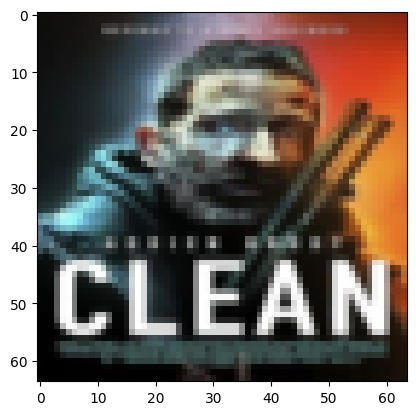

In [3]:
image, target = dataset[5]
print(class_to_idx)

plt.imshow(image.permute((1, 2, 0)))

## Define the Network

In [4]:
class PosterGeneratorNetwork(L.LightningModule):
    def __init__(
        self,
        image_size: int,
        class_embedding_size: int,
        class_to_idx: list[str],
        num_timesteps: int,
    ):
        super(PosterGeneratorNetwork, self).__init__()

        self._image_size = image_size
        self._num_timesteps = num_timesteps
        self._class_to_idx = class_to_idx

        self._class_embedding = nn.Embedding(len(class_to_idx), class_embedding_size)

        self._image_channels = 3

        self._model = UNet2DModel(
            sample_size=image_size,
            in_channels=self._image_channels + class_embedding_size,
            out_channels=self._image_channels,
            block_out_channels=(128, 256, 256),
            down_block_types=("DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
        )

        self._noise_scheduler = DDPMScheduler(
            num_train_timesteps=self._num_timesteps, beta_schedule="squaredcos_cap_v2"
        )

        self._loss_fcn = nn.MSELoss()

    @property
    def num_classes(self):
        return len(self._class_to_idx)

    @property
    def class_to_idx(self):
        return self._class_to_idx

    def forward(self, x, t, class_idx):

        class_conditioning = self._class_embedding(class_idx)

        class_conditioning = class_conditioning.reshape(
            (*class_conditioning.shape, 1, 1)
        ).expand((*class_conditioning.shape, *x.shape[2:]))

        image_input = torch.cat((x, class_conditioning), dim=1)

        return self._model(image_input, t).sample

    def training_step(self, batch, batch_idx):

        images, labels = batch

        noise = torch.randn_like(images).to(self.device)

        timesteps = (
            torch.randint(0, self._num_timesteps - 1, (images.shape[0],))
            .long()
            .to(self.device)
        )

        noisy_x = self._noise_scheduler.add_noise(images, noise, timesteps)

        pred = self(noisy_x, timesteps, labels)

        loss = self._loss_fcn(pred, noise)

        self.log("loss", loss)

        return {"loss": loss}

    def generate_images(self, labels: torch.Tensor | list):
        if isinstance(labels, list):
            labels = torch.Tensor(labels)

        labels = labels.long().to(self.device)

        x = torch.randn(
            labels.shape[0], self._image_channels, self._image_size, self._image_size
        ).to(self.device)

        for indx, t in enumerate(self._noise_scheduler.timesteps):
            with torch.no_grad():
                residual = self(x, t, labels)

            x = self._noise_scheduler.step(residual, t, x).prev_sample

        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        lr_scheduler = ExponentialLR(optimizer, gamma=0.99)
        return optimizer


class_embedding_size = 4
num_timesteps = 1000

task = PosterGeneratorNetwork(
    image_size=IMAGE_SIZE,
    class_embedding_size=class_embedding_size,
    class_to_idx=class_to_idx,
    num_timesteps=num_timesteps,
)

In [5]:
def plot_images(images, labels):
    fig, ax = plt.subplots(images.shape[0], figsize=(16, 16))

    images = images.detach().cpu()

    images -= images.min(dim=2, keepdim=True).values.min(dim=3, keepdim=True).values
    images /= images.max(dim=2, keepdim=True).values.max(dim=3, keepdim=True).values

    for image, ax, label in zip(images, ax, labels):
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(label)

    return fig


class GenerateImagesCallback(L.Callback):
    def __init__(self, every_n_epoch: int, num_images: int = 4):
        super(GenerateImagesCallback, self).__init__()
        self._every_n_epoch = every_n_epoch
        self._counter = 0
        self._generator = torch.Generator().manual_seed(9999)
        self._fid = FrechetInceptionDistance(
            normalize=True, reset_real_features=False
        ).cuda()

        self._num_images = num_images

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Naive approach, all train images are fed to the FID model
        images, labels = batch

        self._fid.update(images, real=True)

    def _log_fid(self, generated_images):

        self._fid.update(generated_images, real=False)

        self.log("fid", self._fid.compute())

        self._fid.reset()

    def on_train_epoch_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        self._counter += 1

        if self._counter % self._every_n_epoch == 0 or self._counter == 1:
            # Create image
            labels = torch.randint(
                0, pl_module.num_classes, (self._num_images,), generator=self._generator
            ).tolist()

            images = pl_module.generate_images(labels)

            self._log_fid(images)

            fig = plot_images(images, [pl_module.class_to_idx[x] for x in labels])

            images_dir = Path(pl_module.logger.log_dir) / "images"
            images_dir.mkdir(exist_ok=True, parents=True)

            fig.savefig(images_dir / f"images_{self._counter}.png")


generate_images_callback = GenerateImagesCallback(every_n_epoch=10)
checkpoint_callback = ModelCheckpoint(monitor="fid")

In [6]:
batch_size = 32
dataloader = utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
trainer = L.Trainer(
    accelerator="cuda" if torch.cuda.is_available() else "cpu",
    min_epochs=1,
    max_epochs=500,
    callbacks=[
        generate_images_callback,
        checkpoint_callback,
        DeviceStatsMonitor(cpu_stats=True),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(task, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type        | Params | Mode 
---------------------------------------------------------
0 | _class_embedding | Embedding   | 16     | train
1 | _model           | UNet2DModel | 25.8 M | train
2 | _loss_fcn        | MSELoss     | 0      | train
---------------------------------------------------------
25.8 M    Trainable params
0         Non-trainable params
25.8 M    Total params
103.373   Total estimated model params size (MB)
220       Modules in train mode
0         Modules in eval mode
/home/john/mp/diffusion-movie-posters/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/john/mp/diffusion-movie-posters/env/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:

Training: |          | 0/? [00:00<?, ?it/s]

/home/john/mp/diffusion-movie-posters/env/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='fid')` could not find the monitored key in the returned metrics: ['loss', 'epoch', 'step']. HINT: Did you call `log('fid', value)` in the `LightningModule`?
